# Preprocessing
Parse and clean fMRI data before running searchlight analysis

In [1]:
# Import dependencies
import numpy as np
import nibabel as nib # load nifti files
import glob # load files from a directory
from nilearn import image as nli
from nilearn import plotting
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score


In [2]:
# define paths
import os

data_path = "../data"
results_path = "../results"

In [3]:
def load_data(data_path):
    """
    Load all fMRI data from the data directory
    returns a list of nifti objects inside of a data array
    """
    # Check if the data path exists
    if not os.path.exists(data_path):
        raise ValueError("Data path does not exist")
    
    dataset = []
    data_path = os.path.join(data_path, '')
    pattern = os.path.join(data_path, 'sub-*', 'func', '*.nii.gz')
    files = glob.glob(pattern, recursive=True)

    # Check if the file exists
    if not files:
        raise FileNotFoundError("No files found in the", pattern)
    
    for file in files:
        try:
            img = nib.load(file)
            dataset.append(img)
            print(f"Successfully loaded: {file}")
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue
    
    if not dataset:
        raise ValueError("No valid NIfTI files found in the {pattern}")
        
    return dataset

# load datasetsx
try:
    data_path_visual = os.path.join(os.path.dirname(os.getcwd()), "data")
    print("looking for data in:", data_path_visual)
    dataset_visual = load_data(data_path_visual)
    print("Final dataset array:", dataset_visual)
except Exception as e:
    print(f"Error loading data: {str(e)}")  



looking for data in: /Users/jaslavie/Desktop/attention/data
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-213/func/sub-213_task-Conj9Inh_acq-a_bold.nii.gz
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-213/func/sub-213_task-Feat9Inh_acq-b_bold.nii.gz
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-213/func/sub-213_task-Feat19Sel_acq-b_bold.nii.gz
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-213/func/sub-213_task-Conj19Sel_acq-a_bold.nii.gz
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-213/func/sub-213_task-Feat1Inh_acq-b_bold.nii.gz
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-213/func/sub-213_task-Conj1Inh_acq-a_bold.nii.gz
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-214/func/sub-214_task-Conj1Inh_acq-a_bold.nii.gz
Successfully loaded: /Users/jaslavie/Desktop/attention/data/sub-214/func/sub-214_task-Conj19Sel_acq-a_bold.nii.gz
Successfully loaded: /Users/jasla

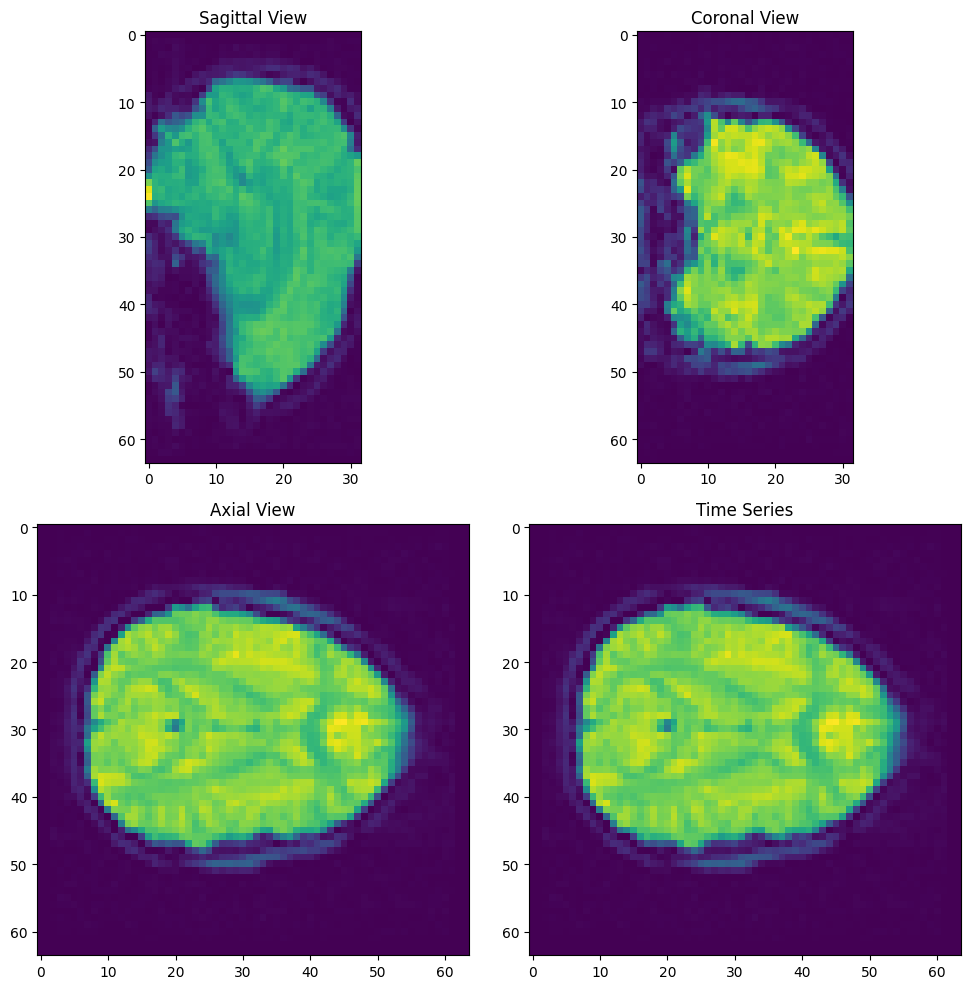

array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  1.,  1., ...,  1.,  1.,  2.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  2.,  0., ...,  2.,  1.,  1.]],

        [[ 4., 11.,  6., ..., 10.,  8., 12.],
         [ 7., 14.,  2., ...,  7.,  6.,  4.],
         [ 7.,  6., 14., ...,  4.,  8.,  6.],
         ...,
         [ 1.,  3.,  3., ...,  5.,  3., 10.],
         [ 5., 11.,  7., ...,  9.,  5., 14.],
         [ 5., 11.,  5., ..., 16.,  5.,  9.]],

        ...,

        [[ 7.,  6., 11., ...,  3.,  8., 11.],
         [ 6.,  3., 10., ...,  3., 11.,  3.],
         [ 6.,  2.

In [4]:
# Visualize the data
import matplotlib.pyplot as plt
def visualize_data(data):
    """
    Visualize the data using nilearn's plotting functions
    """
    # Extract the data array and affine matrix from the nifti object
    data_array = data.get_fdata()
    affine = data.affine

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    x, y, z, t = data_array.shape
    middle_x = x // 2 # get the middle slice in the x direction
    middle_y = y // 2
    middle_z = z // 2
    middle_t = t // 2

    # Plot views at a middle timepoint
    axes[0, 0].imshow(data_array[middle_x, :, :, middle_t])
    axes[0, 0].set_title('Sagittal View')

    axes[0, 1].imshow(data_array[:, middle_y, :, middle_t])
    axes[0, 1].set_title('Coronal View')

    axes[1, 0].imshow(data_array[:, :, middle_z, middle_t])
    axes[1, 0].set_title('Axial View')

    axes[1, 1].imshow(data_array[:, :, middle_z, middle_t])
    axes[1, 1].set_title('Time Series')

    plt.tight_layout()
    plt.show()

    return data_array

visualize_data(dataset_visual[0])


### Clean Data
We will run the following cleaning steps:
1. Smooth the data
2. Detrend the data
3. Remove motion outliers

Cleaned Visual Data
Smoothed Data
Data shape: 64 x 64 x 32 x 156


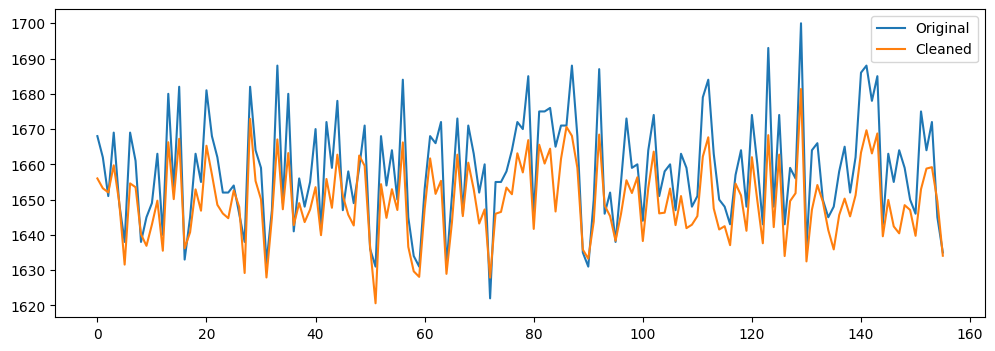

/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/image/image.py:1271: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


Detrended Data
Data shape: 64 x 64 x 32 x 156


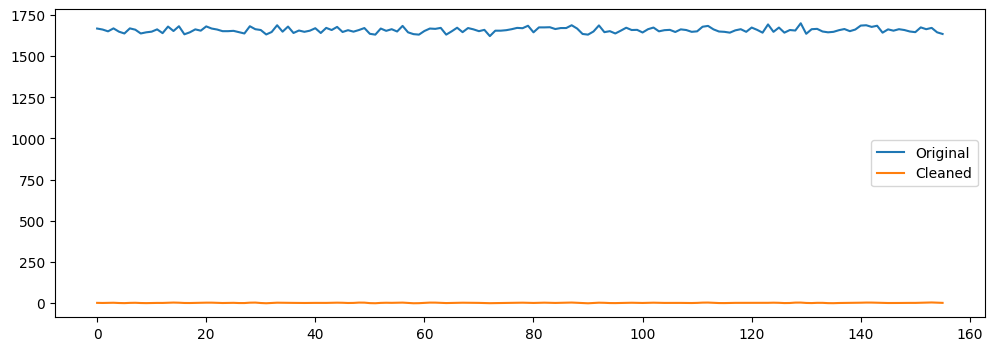

../data/sub-213/func/sub-213_task-Conj1Inh_acq-a_events.tsv
../data/sub-213/func/sub-213_task-Feat19Sel_acq-b_events.tsv
../data/sub-213/func/sub-213_task-Conj9Inh_acq-a_events.tsv
../data/sub-213/func/sub-213_task-Conj19Sel_acq-a_events.tsv
../data/sub-213/func/sub-213_task-Feat1Inh_acq-b_events.tsv
../data/sub-213/func/sub-213_task-Feat9Inh_acq-b_events.tsv
../data/sub-214/func/sub-214_task-Conj19Sel_acq-a_events.tsv
../data/sub-214/func/sub-214_task-Conj9Inh_acq-a_events.tsv
../data/sub-214/func/sub-214_task-Conj1Inh_acq-a_events.tsv
../data/sub-214/func/sub-214_task-Feat9Inh_acq-a_events.tsv
../data/sub-222/func/sub-222_task-Feat9Inh_acq-a_events.tsv
../data/sub-222/func/sub-222_task-Conj1Inh_acq-a_events.tsv
../data/sub-222/func/sub-222_task-Conj19Sel_acq-a_events.tsv
../data/sub-222/func/sub-222_task-Conj9Inh_acq-a_events.tsv
../data/sub-222/func/sub-222_task-Feat1Inh_acq-a_events.tsv
../data/sub-222/func/sub-222_task-Feat19Sel_acq-a_events.tsv
../data/sub-225/func/sub-225_task-F

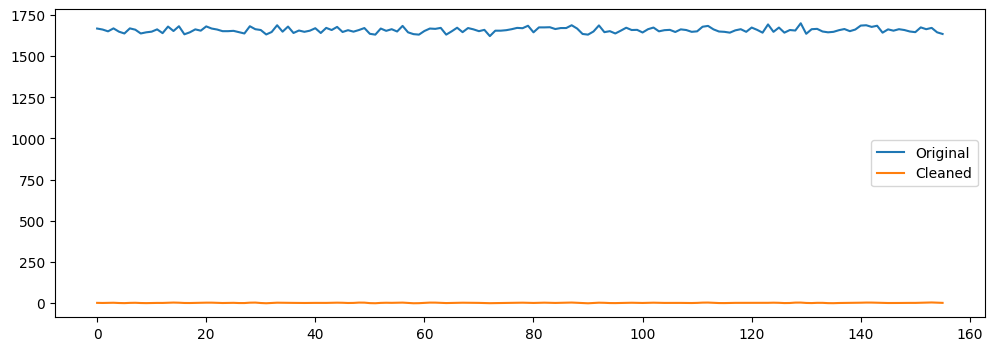

Data shape: 64 x 64 x 32 x 156


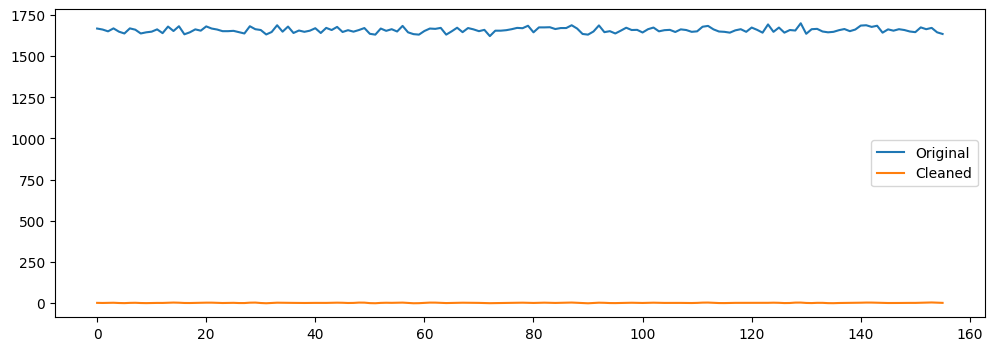

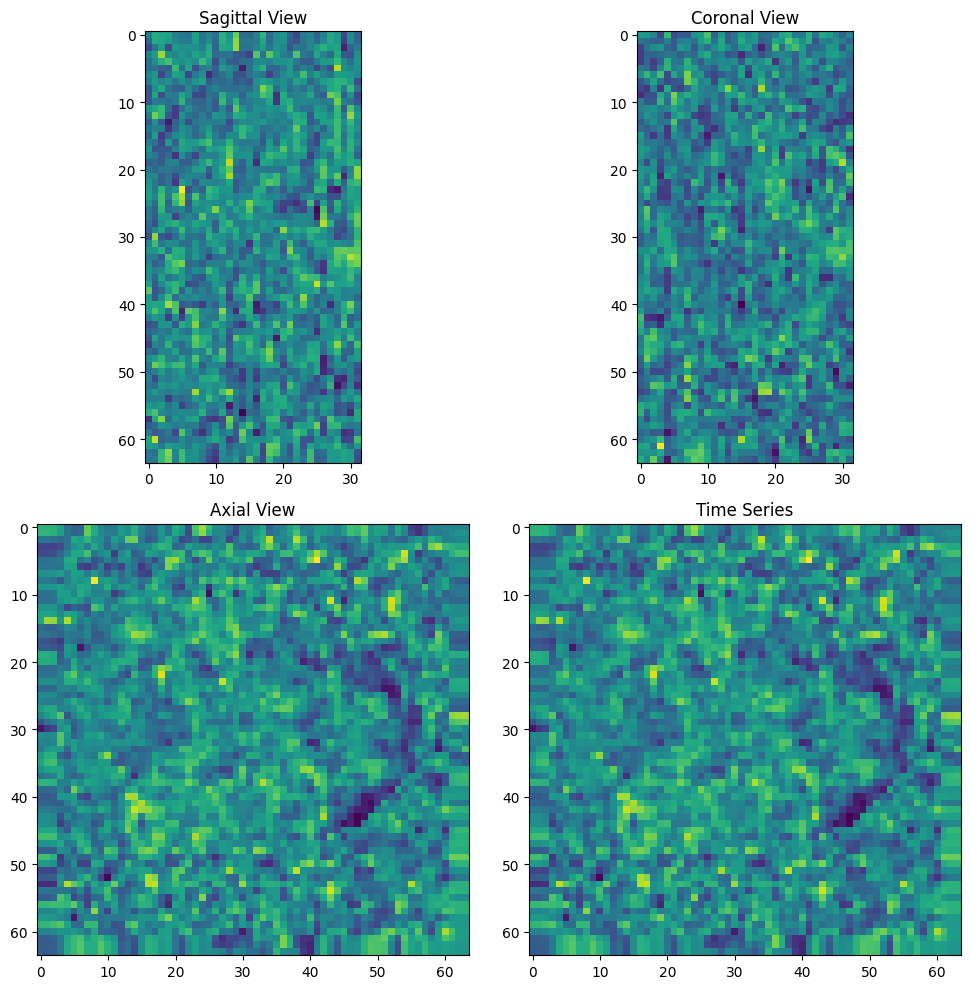

array([[[[-6.46959320e-02,  2.28939557e+00,  1.39221048e+00, ...,
          -1.47746801e+00, -1.55336177e+00,  1.23200737e-01],
         [-6.99061006e-02,  2.46360326e+00,  1.30194056e+00, ...,
          -1.41662014e+00, -1.28911948e+00,  1.37943193e-01],
         [-8.73259827e-02,  3.64788830e-01,  2.07040930e+00, ...,
           3.93138856e-01, -4.43333209e-01, -1.15095943e-01],
         ...,
         [ 5.09344216e-04,  5.57386875e-02,  1.13226414e+00, ...,
          -1.83754575e+00, -2.64180517e+00,  1.64495334e-02],
         [-7.40127414e-02,  2.50558662e+00,  1.68158770e+00, ...,
           9.05171096e-01,  3.14829171e-01, -8.24857410e-03],
         [-8.77247527e-02,  2.25380158e+00,  1.56589222e+00, ...,
           1.29435825e+00,  8.27250361e-01, -2.72532292e-02]],

        [[-6.38872683e-02,  2.24264789e+00,  1.00009549e+00, ...,
          -1.24611115e+00, -1.28798699e+00,  5.85773624e-02],
         [-3.59239168e-02,  1.21621907e+00, -1.71792090e-01, ...,
          -5.57728624e

In [5]:
from nilearn import image as nli
from nilearn import plotting
import pandas as pd

def smooth_data(resampled_data, data):
    """
    Smooth the data by applying a Gaussian filter
    """
    smoothed_data = nli.smooth_img(resampled_data, fwhm=4)

    print("Smoothed Data")
    plot_data(smoothed_data, data)

    return smoothed_data

def detrend_data(smoothed_data, data):
    """
    Detrend the data by removing frequency noise
    """
    TR = smoothed_data.header['pixdim'][4] # get the reptition time from the header
    func_d= nli.image.clean_img(
        smoothed_data, 
        detrend=True, 
        standardize='zscore', 
        t_r=TR, 
        low_pass=0.1,
        high_pass=0.01
    )

    print("Detrended Data")
    plot_data(func_d, data)

    return func_d

def remove_motion_outliers(func_d, data):
    """
    Remove motion outliers from the data
    """
    # extract time series data from tsv files
    tsv_files = glob.glob(os.path.join(data_path, 'sub-*/func/*.tsv'))
    for tsv_file in tsv_files:
        print(tsv_file)

    # initialize cleaned data as the detrended data
    cleaned_data = func_d

    for tsv_file in tsv_files:
        try:
            ts_confounds = pd.read_csv(tsv_file, sep='\t')
            # extract the motion parameters
            motion_params = ts_confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
            # regress the motion parameters from the data
            cleaned_data = nli.clean_img(
                func_d, 
                confounds = motion_params,
                standardize = False
            )          
        except Exception as e:
            print(f"Error processing {tsv_file}: {str(e)}")
            continue

    print("Motion Outliers Removed Data")
    plot_data(cleaned_data, data)

    return cleaned_data

def plot_data(cleaned_data, data):
    """
    Plot data samples
    """

    x, y, z, t = cleaned_data.shape
    print(f"Data shape: {x} x {y} x {z} x {t}")

    # Retrieve middle points
    mid_x = x // 2
    mid_y = y //2 
    mid_z = z // 2
    mid_t = t // 2

    # Plot the time series at the middle points
    plt.figure(figsize=(12, 4))
    plt.plot(np.transpose(data.get_fdata()[mid_x, mid_y, mid_z, :]))
    plt.plot(np.transpose(cleaned_data.get_fdata()[mid_x, mid_y, mid_z, :]))
    plt.legend(['Original', 'Cleaned'])
    plt.show()

    return cleaned_data

def clean_data(data):
    """
    Clean the data by removing artifacts and normalizing the data
    """
    # Step 1: Compute the mean image and resample data
    mean_img = nli.mean_img(data)
    resampled_data = nli.resample_to_img(data, mean_img)
    
    # Step 2: Apply spatial smoothing
    smoothed_data = smooth_data(resampled_data, data)
    
    # Step 3: Detrend and standardize the data
    detrended_data = detrend_data(smoothed_data, data)
    
    # Step 4: Remove motion outliers
    motion_outliers_removed_data = remove_motion_outliers(detrended_data, data)
    cleaned_data = motion_outliers_removed_data

    # plot the data
    plot_data(cleaned_data, data)

    return cleaned_data


print("Cleaned Visual Data")
clean_data_visual = clean_data(dataset_visual[0])
visualize_data(clean_data_visual)

### Assess Data Quality
Evaluate the quality of the cleaned data

In [10]:
def calculate_quality_metrics(original_data, cleaned_data):
    """ 
    Quantify the effectiveness of data cleaning
    """
    # convert data to a numpy array 
    original_data_array = original_data.get_fdata()
    print("Sample of original data: ", original_data_array[0, 0, 0, :])
    cleaned_data_array = cleaned_data.get_fdata()
    print("Sample of cleaned data: ", cleaned_data_array[0, 0, 0, :])

    metrics = {} # initialize array to store calculated metrics data
    
    # Add small epsilon to handle division by zero
    eps = np.finfo(float).eps

    # calculate the signal-to-noise ratio (SNR)
    metrics['snr_original'] = np.mean(np.abs(original_data_array)) / (np.std(original_data_array) + eps)
    metrics['snr_cleaned'] = np.mean(np.abs(cleaned_data_array)) / (np.std(cleaned_data_array) + eps)
    metrics['snr_improvement'] = (metrics['snr_cleaned'] - metrics['snr_original']) / (metrics['snr_original'] + eps)

    # calculate the temporal signal-to-noise ratio (tSNR)
    metrics['tsnr_original'] = np.mean(np.mean(original_data_array, axis=-1) / 
                                    np.std(original_data_array, axis=-1))
    metrics['tsnr_cleaned'] = np.mean(np.mean(cleaned_data_array, axis=-1) / 
                                    np.std(cleaned_data_array, axis=-1))
    metrics['tsnr_improvement'] = (metrics['tsnr_cleaned'] - metrics['tsnr_original']) / metrics['tsnr_original']

    # Calculate outliers using z-score
    from scipy.stats import zscore
    z_orig = zscore(original_data_array.ravel())
    z_clean = zscore(cleaned_data_array.ravel())

    metrics['outlier_fraction_original'] = np.sum(np.abs(z_orig) > 3) / len(z_orig)
    metrics['outlier_fraction_cleaned'] = np.sum(np.abs(z_clean) > 3) / len(z_clean)
    metrics['outlier_fraction_reduction'] = ((metrics['outlier_fraction_original'] - 
                                            metrics['outlier_fraction_cleaned']) / 
                                            metrics['outlier_fraction_original'])

    return metrics

def assess_data_quality(data, thresholds=None):
    """ 
    Assess if the data meets quality standards for model training
    """
    if thresholds is None:
        thresholds = {
            'min_snr': 1.0, # indicates that the SNR is a 100% improvement from original
            'min_tsnr': 15.0,
            'max_outlier_fraction': 0.05,
        }
    
    quality_checks = {
        'SNR Check': metrics['snr_cleaned'] > thresholds['min_snr'],
        'tSNR Check': metrics['tsnr_cleaned'] > thresholds['min_tsnr'],
        'Outlier Fraction Check': metrics['outlier_fraction_cleaned'] < thresholds['max_outlier_fraction'],
    }

    return quality_checks

metrics = calculate_quality_metrics(dataset_visual[8], clean_data_visual)
quality_assessment = assess_data_quality(metrics)

print("\nData Quality Metrics: ")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}") # print the metrics with 2 decimal places

print("\nData Quality Checks: ")
for check, passed in quality_assessment.items():
    status = "Passed" if passed else "failed"
    print(f"{check}: {status}")


Sample of original data:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample of cleaned data:  [-6.46959320e-02  2.28939557e+00  1.39221048e+00  3.18487763e-01
  1.27903879e+00  1.33342993e+00 -2.95197845e-01 -6.10386908e-01
  2.54773349e-01 -3.38709712e-01 -1.73270929e+00 -1.72828352e+00
 -7.47843981e-01 -2.75336578e-02  5.61453223e-01  7.95775235e-01
 -1.33313328e-01 -1.12528992e+00 -6.14120327e-02  2.31955838e+00
  3.06563282e+00  1.44059241e+00 -5.76686084e-01 -1.37028968e+00
 -9.02621448e-01 -2.04948708e-01 -4.55110013e-01 -1.26789522e+00
 -9.18503642e-01  

/var/folders/t4/kq2w5sp97l11x3ky8lqjsf800000gn/T/ipykernel_44835/3491644807.py:22: RuntimeWarning: divide by zero encountered in divide
  metrics['tsnr_original'] = np.mean(np.mean(original_data_array, axis=-1) /
/var/folders/t4/kq2w5sp97l11x3ky8lqjsf800000gn/T/ipykernel_44835/3491644807.py:22: RuntimeWarning: invalid value encountered in divide
  metrics['tsnr_original'] = np.mean(np.mean(original_data_array, axis=-1) /



Data Quality Metrics: 
snr_original: 0.64
snr_cleaned: 0.78
snr_improvement: 0.23
tsnr_original: nan
tsnr_cleaned: 0.00
tsnr_improvement: nan
outlier_fraction_original: 0.00
outlier_fraction_cleaned: 0.00
outlier_fraction_reduction: -483.65

Data Quality Checks: 
SNR Check: failed
tSNR Check: failed
Outlier Fraction Check: Passed


In [11]:
# save the cleaned data
nib.save(clean_data_visual, "../results/visual/cleaned_data_visual.nii.gz")
print("Visual data shape: ", clean_data_visual.shape)

Visual data shape:  (64, 64, 32, 156)
